# Test positional embedding

To be sure that our model can take a positional embedding and learn a meaningful signal from it, create a test where:
* First half of the sequence has Gaussian noise $\geq 0$
* Second half of the sequence hsa Gaussian noise $\leq 0$

Use variable sequence lengths such that the model cannot just memorize certain outputs to be positive/negative.

In [1]:
import os, sys
import json

import numpy as np
import matplotlib.pyplot as plt

import torch

SRC_DIR = os.path.join(os.path.dirname(os.getcwd()), "protdiff")
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import plotting

In [2]:
MODEL_DIR = "/home/t-kevinwu/projects/protein_diffusion/models_temp/synnoise"
epoch = 1999
with open(f"{MODEL_DIR}/valid_preds/{epoch}_preds.json") as source:
    valid_preds = json.load(source)
    for k, v in valid_preds.items():
        valid_preds[k] = np.array(v)
valid_preds.keys()

dict_keys(['known_noise', 'predicted_noise', 'attn_mask', 'losses'])

In [3]:
with open(os.path.join(MODEL_DIR, "git_sha.txt")) as source:
    git_sha = source.read().strip()
git_sha

'6f644e6976de19c2fa824d8ec9b291df191f694f'

In [4]:
with open(os.path.join(MODEL_DIR, "training_args.json")) as source:
    params = json.load(source)
print(params)

{'results_dir': 'synnoise', 'shift_angles_zero_twopi': False, 'noise_prior': 'gaussian', 'timesteps': 250, 'variance_schedule': 'cosine', 'variance_scale': 1.0, 'implementation': 'pytorch_encoder', 'time_encoding': 'gaussian_fourier', 'num_hidden_layers': 12, 'hidden_size': 384, 'intermediate_size': 768, 'num_heads': 12, 'position_embedding_type': 'absolute', 'dropout_p': 0.1, 'gradient_clip': 1.0, 'lr': 5e-05, 'loss': 'huber', 'l2_norm': 0.0, 'l1_norm': 0.0, 'circle_reg': 0.0, 'min_epochs': 1000, 'max_epochs': 2000, 'early_stop_patience': 0, 'lr_scheduler': '', 'use_swa': False, 'subset': 500, 'exhaustive_validation_t': False, 'syn_noiser': 'halfhalf', 'single_dist_debug': False, 'single_angle_debug': False, 'single_timestep_debug': False, 'batch_size': 128, 'multithread': True}


In [5]:
valid_preds['attn_mask'].shape

(26, 512)

In [6]:
valid_preds['known_noise'].shape

(26, 512, 1)

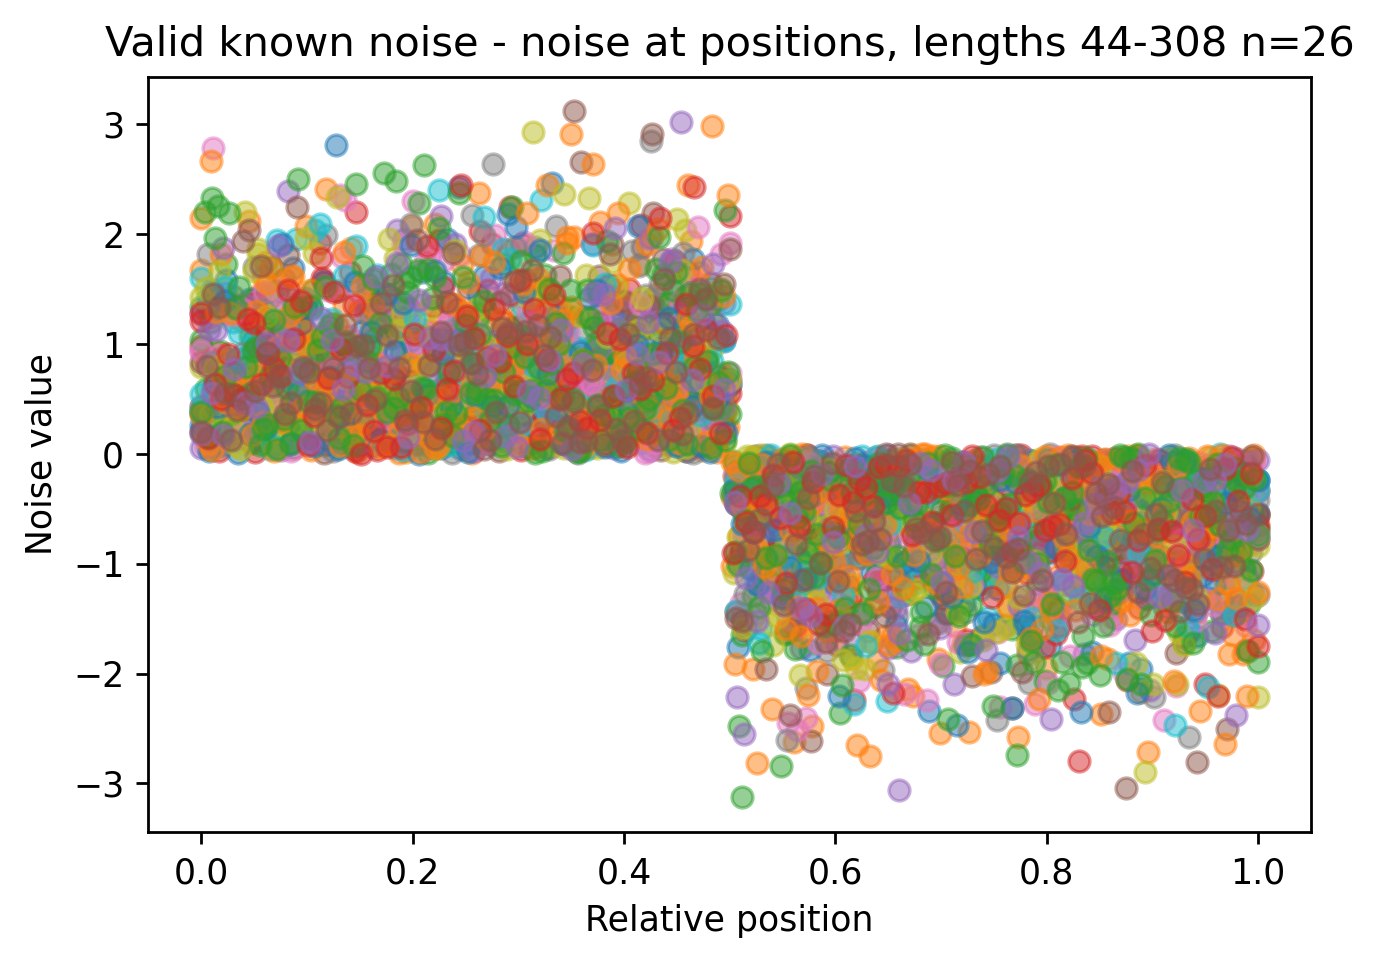

In [7]:
# Validate the true noise behaves as designed
def plot_by_position(preds, attn_mask, title_prefix:str=""):
    fig, ax = plt.subplots(dpi=250)
    lengths = []
    for mat, mask in zip(preds, attn_mask):
        mat = mat.squeeze()
        vals = mat[np.where(mask)]
        pos = np.linspace(0, 1, num=len(vals))
        ax.scatter(pos, vals, alpha=0.5)
        lengths.append(len(vals))

    title = "noise at positions, lengths {}-{} n={}".format(min(lengths), max(lengths), len(lengths))
    if title_prefix:
        title = ' - '.join([title_prefix.strip(), title])
    ax.set(
        xlabel="Relative position",
        ylabel="Noise value",
        title=title
    )
    return fig

plot_by_position(valid_preds['known_noise'], ~valid_preds['attn_mask'], title_prefix="Valid known noise").show()

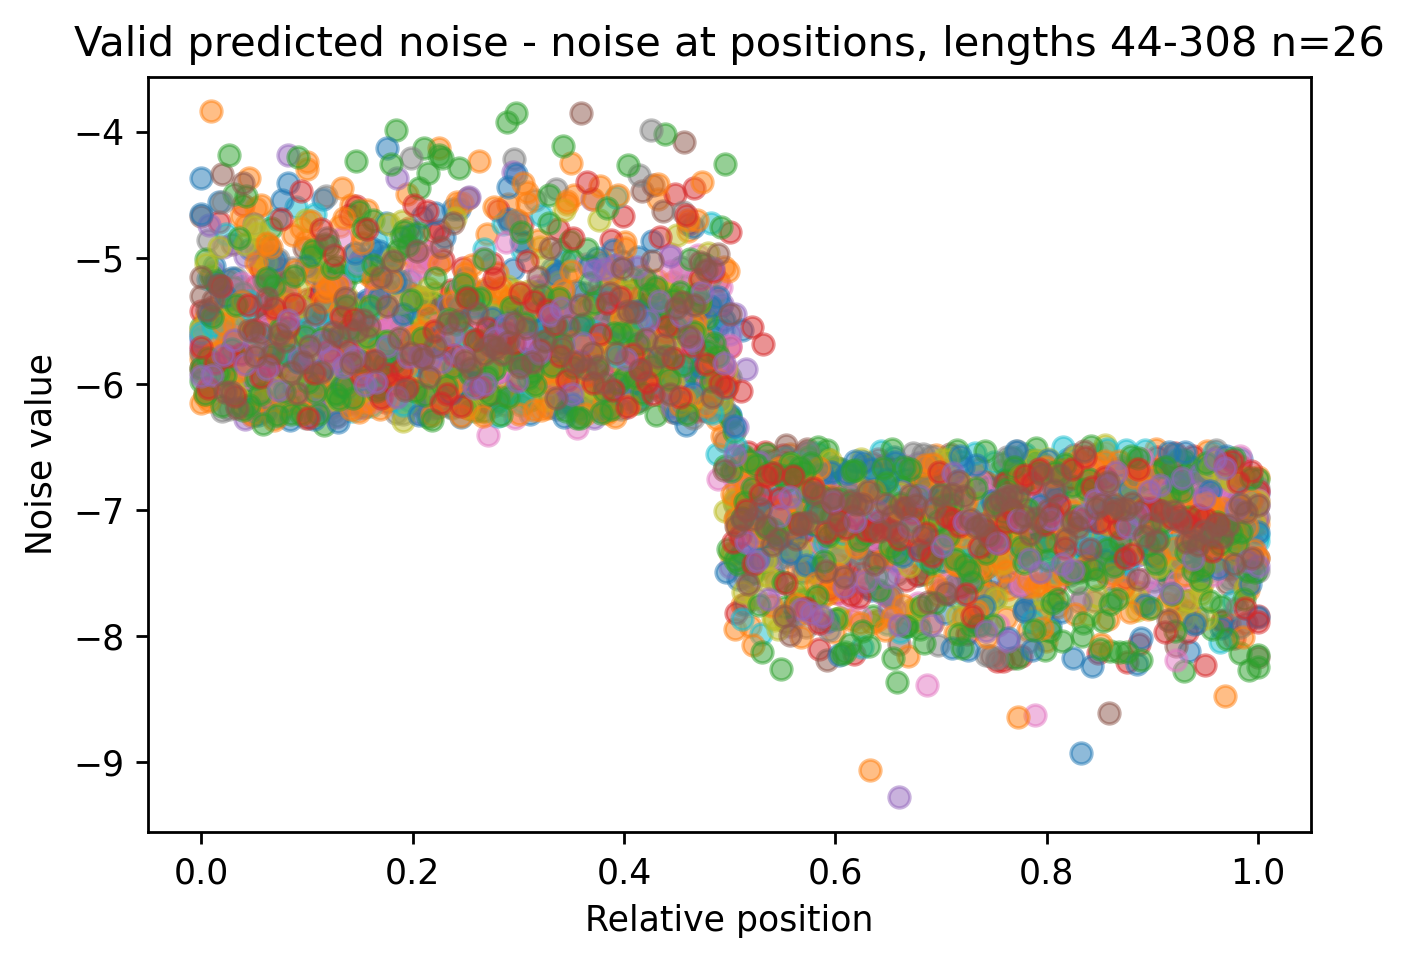

In [8]:
# Plot predicted noise
plot_by_position(valid_preds['predicted_noise'], ~valid_preds['attn_mask'], title_prefix="Valid predicted noise").show()

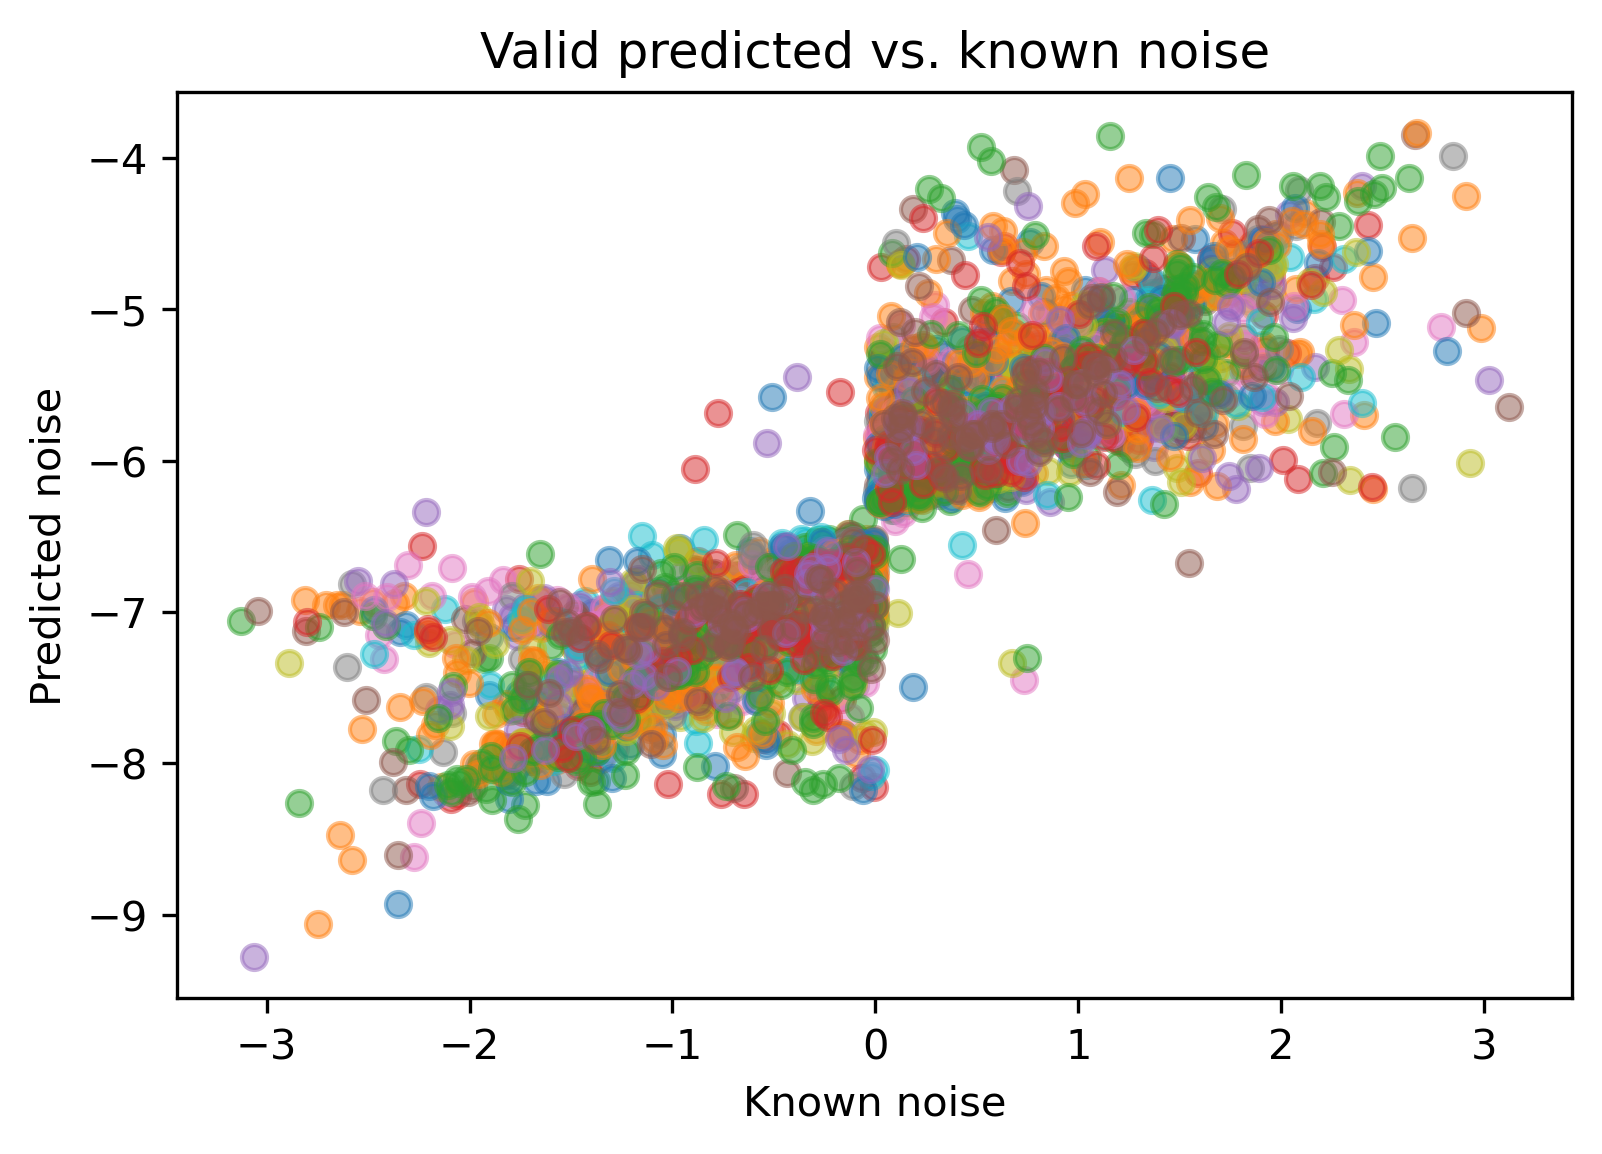

In [9]:
def plot_scatter(preds, title:str):
    fig, ax = plt.subplots(dpi=300)
    for truth, preds, mask in zip(valid_preds['known_noise'], valid_preds['predicted_noise'], ~valid_preds['attn_mask']):
        truth = truth.squeeze()[np.where(mask)]
        preds = preds.squeeze()[np.where(mask)]
        ax.scatter(truth, preds, alpha=0.5)
    
    ax.set(
        xlabel="Known noise",
        ylabel="Predicted noise",
        title=title,
    )
    return fig

plot_scatter(valid_preds, title="Valid predicted vs. known noise").show()

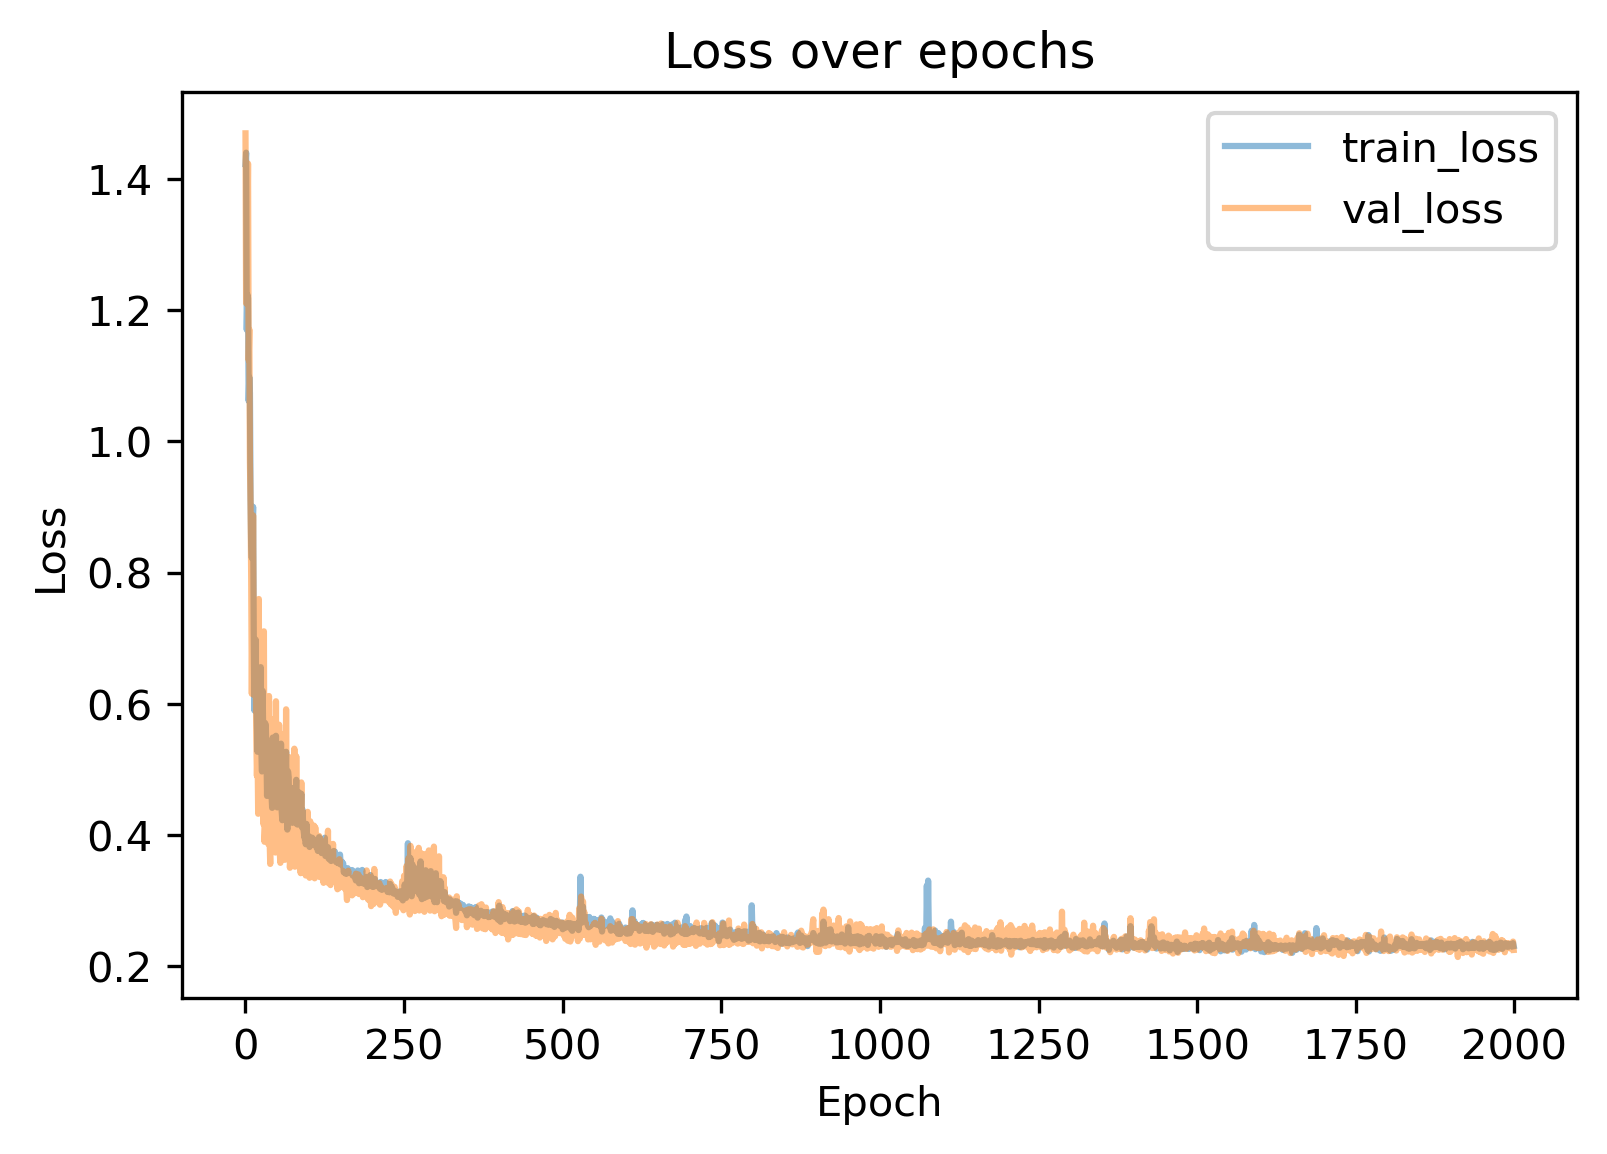

In [10]:
# Plot the losses

plotting.plot_losses(
    os.path.join(MODEL_DIR, "logs/lightning_logs/version_0/metrics.csv")
).show()